**CLASSIFIER**

###CUSTOM ARCHITECTURE

In [2]:
!pip install gradient-descent-the-ultimate-optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report


In [4]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# TRANSFORM
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# CIFAR-100
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:02<00:00, 78365217.17it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# DATALOADER
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# 8-CONV LAYER ARCHITECTURE
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [9]:
# MODEL INSTANCE
model = CNN().to(device)


In [10]:
# LOSS / OPTMIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# MODEL
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss Update
        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    
    train_losses.append(running_loss / len(train_loader))

print("Completed training!")

Epoch [1/5], Batch [100/391], Loss: 4.4538
Epoch [1/5], Batch [200/391], Loss: 4.2648
Epoch [1/5], Batch [300/391], Loss: 4.0624
Epoch [2/5], Batch [100/391], Loss: 3.8570
Epoch [2/5], Batch [200/391], Loss: 3.7634
Epoch [2/5], Batch [300/391], Loss: 3.6423
Epoch [3/5], Batch [100/391], Loss: 3.4576
Epoch [3/5], Batch [200/391], Loss: 3.3836
Epoch [3/5], Batch [300/391], Loss: 3.3166
Epoch [4/5], Batch [100/391], Loss: 3.1696
Epoch [4/5], Batch [200/391], Loss: 3.1082
Epoch [4/5], Batch [300/391], Loss: 3.0326
Epoch [5/5], Batch [100/391], Loss: 2.9009
Epoch [5/5], Batch [200/391], Loss: 2.8596
Epoch [5/5], Batch [300/391], Loss: 2.8113
Completed training!


CUSTOM_MODEL's accuracy on the test data: 28.64%


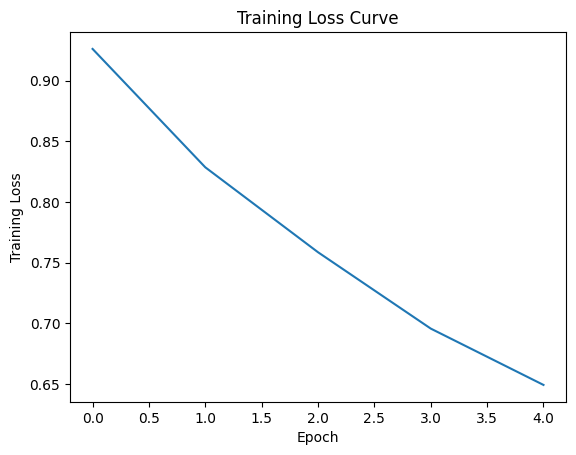

In [12]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = 100 * total_correct / total_samples
print(f"CUSTOM_MODEL's accuracy on the test data: {accuracy:.2f}%")

# Plot the training loss curve
plt.plot(range(num_epochs), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [13]:
# SAVE PARAMS
torch.save(model.state_dict(), 'custom_model.pth')


### FINETUNNING - CUSTOM_MODEL

In [14]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [15]:
# TRANSFORM
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_file_paths =  '/content/drive/MyDrive/dataset/test'
train_file_paths = '/content/drive/MyDrive/dataset/training'
val_file_paths = '/content/drive/MyDrive/dataset/validation'

test_data = ImageFolder(root=test_file_paths, transform=transform)
train_data = ImageFolder(root=train_file_paths, transform=transform)
valid_data = ImageFolder(root=val_file_paths, transform=transform)

# Create DataLoaders for training and validation
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [16]:
# MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN()

In [17]:
model.load_state_dict(torch.load('/content/custom_model.pth'))


<All keys matched successfully>

In [18]:
# REPLACE LAST LAYER 
model.fc_layers = nn.Sequential(
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 5)
)
model.to(device)


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, 

In [19]:
# LOSS / OPTMIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# FINE-TUNNING
num_epochs = 5

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    valid_loss = 0.0

    # Training
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    # Store losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    # Check if validation loss improved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the model

print("Completed fine-tuning!")

Epoch [1/5], Training Loss: 1.6073, Validation Loss: 1.6105
Epoch [2/5], Training Loss: 1.6097, Validation Loss: 1.6081
Epoch [3/5], Training Loss: 1.6089, Validation Loss: 1.6075
Epoch [4/5], Training Loss: 1.6056, Validation Loss: 1.6112
Epoch [5/5], Training Loss: 1.6077, Validation Loss: 1.6088
Completed fine-tuning!


CUSTOM_MODEL's accuracy on the test data: 15.71%


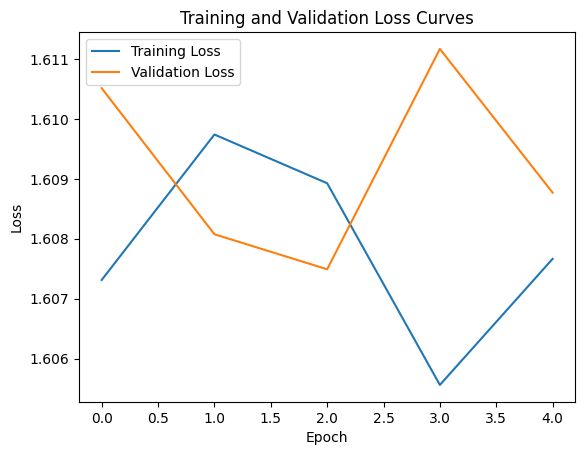

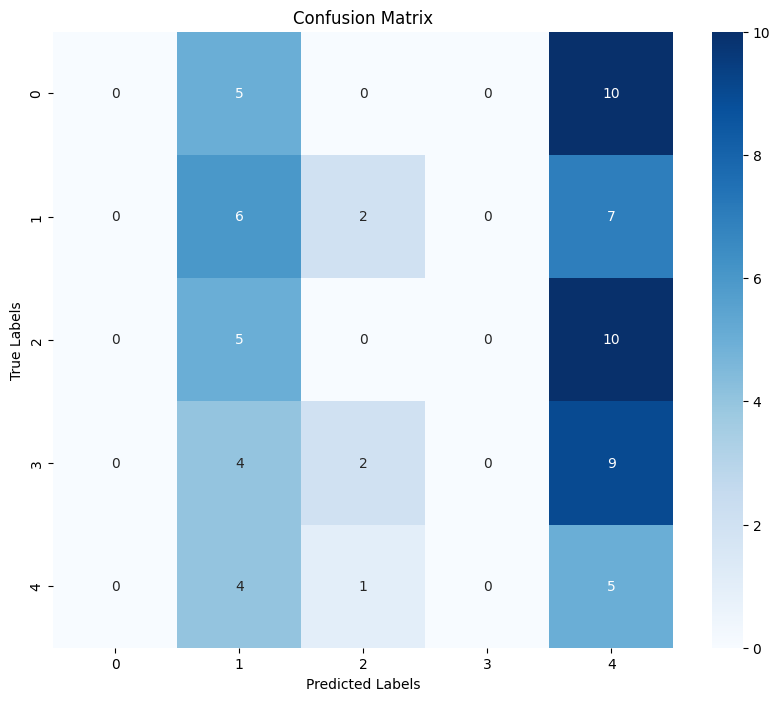

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.25      0.40      0.31        15
           2       0.80      0.27      0.40        15
           3       0.00      0.00      0.00        15
           4       0.12      0.50      0.20        10

    accuracy                           0.21        70
   macro avg       0.23      0.23      0.18        70
weighted avg       0.24      0.21      0.18        70



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# LOSS / MATRIX
model.eval()
total_correct = 0
total_samples = 0
predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        test_labels.extend(labels.tolist())

accuracy = 100 * total_correct / total_samples
print(f"CUSTOM_MODEL's accuracy on the test data: {accuracy:.2f}%")

# Plot the training and validation loss curves
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Create the confusion matrix
predictions = np.array(predictions)
test_labels = np.array(test_labels)
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 scores
predictions = np.array(predictions)
test_labels = np.array(test_labels)
report = classification_report(test_loader.dataset.targets, predictions)
print(report)

In [22]:
torch.save(model.state_dict(), 'custom_model_fined.pth')


### FINETUNNING - MOBILENET_V3_SMALL 

In [23]:
# LOAD ARCHITECTURE
from torchvision.models import mobilenet_v3_small
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# TRANSFORM
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_file_paths =  '/content/drive/MyDrive/dataset/test'
train_file_paths = '/content/drive/MyDrive/dataset/training'
val_file_paths = '/content/drive/MyDrive/dataset/validation'

test_data = ImageFolder(root=test_file_paths, transform=transform)
train_data = ImageFolder(root=train_file_paths, transform=transform)
valid_data = ImageFolder(root=val_file_paths, transform=transform)

# Create DataLoaders for training and validation
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [25]:
# MODEL
model = mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 57.2MB/s]


In [26]:
num_classes = 5
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(train_data.classes))

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [28]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [29]:
# FINETUNNING
num_epochs = 10

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    
    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

    # Calculate average validation loss
    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

    # Check if validation loss improved
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        # Save the model

print("Completed fine-tuning!")

Epoch [1/10], Training Loss: 2.0887, Validation Loss: 1.6805
Epoch [2/10], Training Loss: 1.9801, Validation Loss: 1.6925
Epoch [3/10], Training Loss: 1.9985, Validation Loss: 1.6995
Epoch [4/10], Training Loss: 2.1012, Validation Loss: 1.7145
Epoch [5/10], Training Loss: 2.0457, Validation Loss: 1.7223
Epoch [6/10], Training Loss: 2.0560, Validation Loss: 1.8207
Epoch [7/10], Training Loss: 1.9698, Validation Loss: 1.6804
Epoch [8/10], Training Loss: 2.0070, Validation Loss: 1.7100
Epoch [9/10], Training Loss: 1.9710, Validation Loss: 1.6462
Epoch [10/10], Training Loss: 1.9907, Validation Loss: 1.9568
Completed fine-tuning!


MOBILENET_V3_SMALL's accuracy on the test data: 15.71%


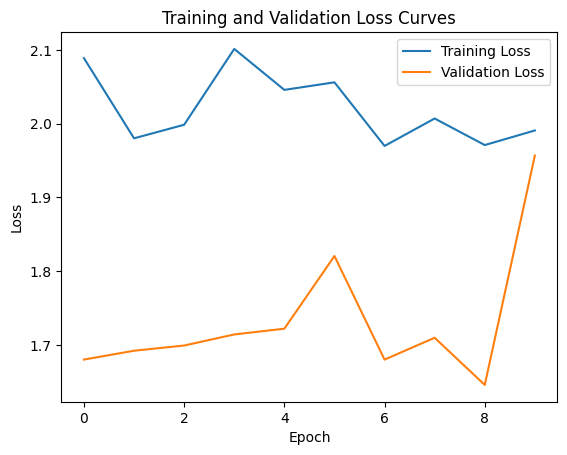

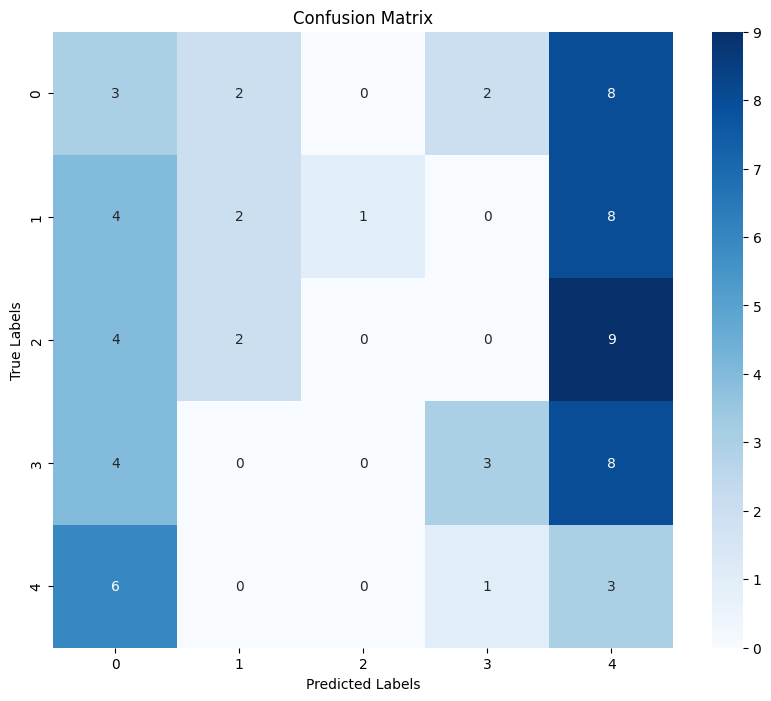

              precision    recall  f1-score   support

           0       0.24      0.33      0.28        15
           1       0.17      0.07      0.10        15
           2       0.00      0.00      0.00        15
           3       0.33      0.13      0.19        15
           4       0.17      0.60      0.26        10

    accuracy                           0.20        70
   macro avg       0.18      0.23      0.16        70
weighted avg       0.18      0.20      0.16        70



In [30]:
# LOSS / MATRIX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
total_correct = 0
total_samples = 0
predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        test_labels.extend(labels.tolist())

accuracy = 100 * total_correct / total_samples
print(f"MOBILENET_V3_SMALL's accuracy on the test data: {accuracy:.2f}%")

# Plot the training and validation loss curves
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Create the confusion matrix
predictions = np.array(predictions)
test_labels = np.array(test_labels)
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 scores
predictions = np.array(predictions)
test_labels = np.array(test_labels)
report = classification_report(test_loader.dataset.targets, predictions)
print(report)

In [31]:
torch.save(model.state_dict(), 'mobilenet_v3_small.pth')


### FINETUNNING - SHUFFLENET_V2_X0_5


In [32]:
# LOAD ARCHITECTURE
from torchvision.models import shufflenet_v2_x0_5
model = shufflenet_v2_x0_5(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 25.9MB/s]


In [33]:
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [35]:
# FINETUNNING
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss Update
        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Completed fine-tuning!")

Epoch [1/20], Loss: 1.6094
Epoch [2/20], Loss: 1.6134
Epoch [3/20], Loss: 1.6123
Epoch [4/20], Loss: 1.6054
Epoch [5/20], Loss: 1.6136
Epoch [6/20], Loss: 1.6082
Epoch [7/20], Loss: 1.6054
Epoch [8/20], Loss: 1.6073
Epoch [9/20], Loss: 1.6040
Epoch [10/20], Loss: 1.6060
Epoch [11/20], Loss: 1.6029
Epoch [12/20], Loss: 1.6004
Epoch [13/20], Loss: 1.6006
Epoch [14/20], Loss: 1.6050
Epoch [15/20], Loss: 1.6059
Epoch [16/20], Loss: 1.6046
Epoch [17/20], Loss: 1.6019
Epoch [18/20], Loss: 1.5997
Epoch [19/20], Loss: 1.5965
Epoch [20/20], Loss: 1.5990
Completed fine-tuning!


SHUFFLENET_V2_X0_5's accuracy on the test data: 24.29%


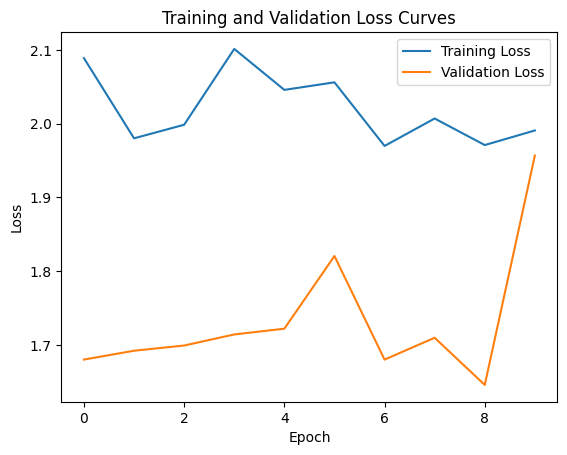

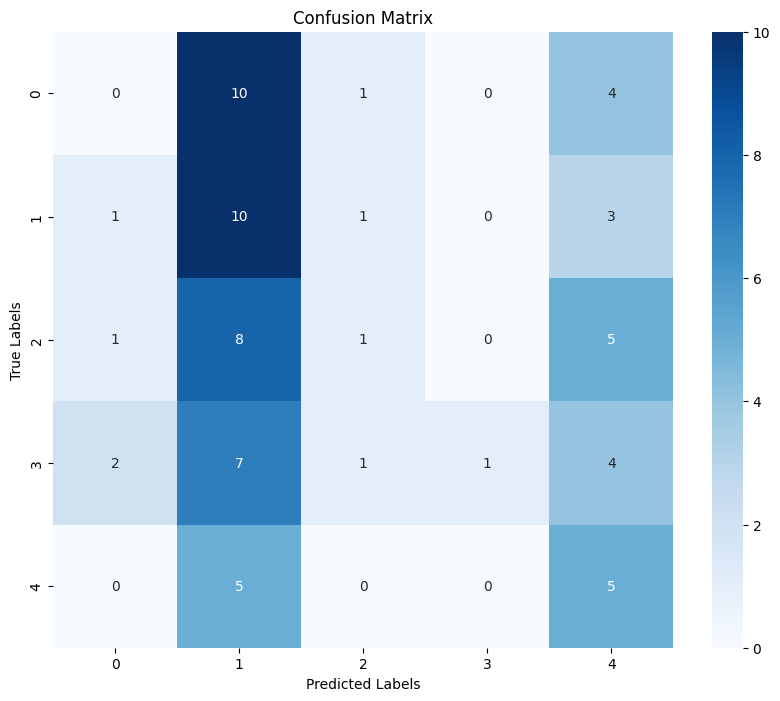

              precision    recall  f1-score   support

           0       0.25      0.07      0.11        15
           1       0.25      0.67      0.36        15
           2       0.25      0.07      0.11        15
           3       1.00      0.07      0.12        15
           4       0.05      0.10      0.06        10

    accuracy                           0.20        70
   macro avg       0.36      0.19      0.15        70
weighted avg       0.38      0.20      0.16        70



In [39]:
# LOSS / MATRIX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
total_correct = 0
total_samples = 0
predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        test_labels.extend(labels.tolist())

accuracy = 100 * total_correct / total_samples
print(f"SHUFFLENET_V2_X0_5's accuracy on the test data: {accuracy:.2f}%")

if len(train_losses) > num_epochs:
    train_losses = train_losses[:num_epochs]
elif len(train_losses) < num_epochs:
    train_losses.extend([None] * (num_epochs - len(train_losses)))

if len(valid_losses) > num_epochs:
    valid_losses = valid_losses[:num_epochs]
elif len(valid_losses) < num_epochs:
    valid_losses.extend([None] * (num_epochs - len(valid_losses)))

# Plot the training and validation loss curves
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Create the confusion matrix
predictions = np.array(predictions)
test_labels = np.array(test_labels)
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 scores
predictions = np.array(predictions)
test_labels = np.array(test_labels)
report = classification_report(test_loader.dataset.targets, predictions)
print(report)

In [40]:
torch.save(model.state_dict(), 'shufflenet_v2_x0_5.pth')


### FINETUNNING - SQUEEZENET1_0


In [41]:
from torchvision.models import squeezenet1_0
model = squeezenet1_0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 33.4MB/s]


In [42]:
num_classes = 5
model.classifier._modules['1'] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [44]:
# FINETUNNING
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss Update
        running_loss += loss.item()

        if batch_idx % 100 == 99:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Completed fine-tuning!")

Epoch [1/20], Loss: 1.9700
Epoch [2/20], Loss: 1.6067
Epoch [3/20], Loss: 1.6097
Epoch [4/20], Loss: 1.6130
Epoch [5/20], Loss: 1.6078
Epoch [6/20], Loss: 1.6095
Epoch [7/20], Loss: 1.6083
Epoch [8/20], Loss: 1.6124
Epoch [9/20], Loss: 1.6099
Epoch [10/20], Loss: 1.6098
Epoch [11/20], Loss: 1.6100
Epoch [12/20], Loss: 1.6094
Epoch [13/20], Loss: 1.6094
Epoch [14/20], Loss: 1.6094
Epoch [15/20], Loss: 1.6094
Epoch [16/20], Loss: 1.6094
Epoch [17/20], Loss: 1.6094
Epoch [18/20], Loss: 1.6094
Epoch [19/20], Loss: 1.6094
Epoch [20/20], Loss: 1.6094
Completed fine-tuning!


SQUEEZENET1_0's accuracy on the test data: 21.43%


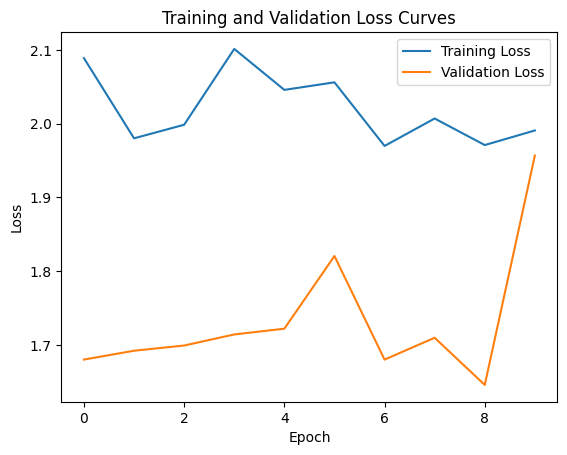

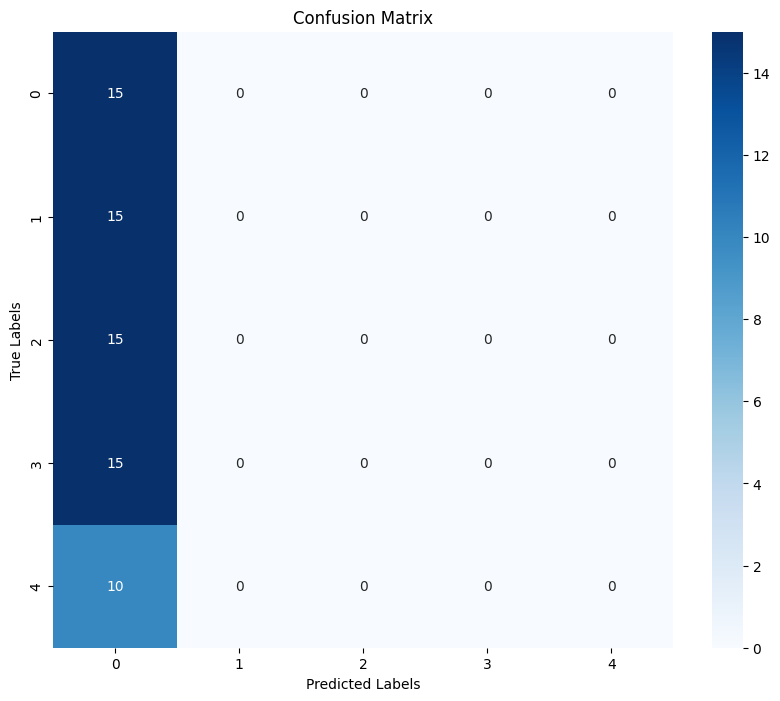

              precision    recall  f1-score   support

           0       0.21      1.00      0.35        15
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10

    accuracy                           0.21        70
   macro avg       0.04      0.20      0.07        70
weighted avg       0.05      0.21      0.08        70



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# LOSS / MATRIX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
total_correct = 0
total_samples = 0
predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        test_labels.extend(labels.tolist())

accuracy = 100 * total_correct / total_samples
print(f"SQUEEZENET1_0's accuracy on the test data: {accuracy:.2f}%")

# Plot the training and validation loss curves
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Create the confusion matrix
predictions = np.array(predictions)
test_labels = np.array(test_labels)
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 scores
predictions = np.array(predictions)
test_labels = np.array(test_labels)
report = classification_report(test_loader.dataset.targets, predictions)
print(report)

In [46]:
torch.save(model.state_dict(), 'squeezenet1_0.pth')
